# Import packages

In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import random
import sc_toolbox
import pertpy 
import rpy2.robjects as robjects
import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import pandas2ri
from rpy2.robjects import r
from modules.deg_analysis import *
sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

# Load dataset

In [2]:
adata = sc.read(
    filename="data/fede_count_clustered.h5ad"
)

# Differential gene expression analysis - Sample level

In [3]:
cell_types = adata.obs["class_name"].cat.categories
adata_pb = aggregate_and_filter(adata, cell_types[0], obs_to_keep=['Sample_Tag', 'class_name'])

for i, cell_type in enumerate(cell_types[1:], start=2):
    adata_cell_type = aggregate_and_filter(adata, cell_type, obs_to_keep=['Sample_Tag', 'class_name'])
    adata_pb = adata_pb.concatenate(adata_cell_type)

adata_pb.layers['counts'] = adata_pb.X.copy()

### Pseudo-replicates PCA

In [4]:
sc.pp.normalize_total(adata_pb, target_sum=1e6)
sc.pp.log1p(adata_pb)
sc.pp.pca(adata_pb)

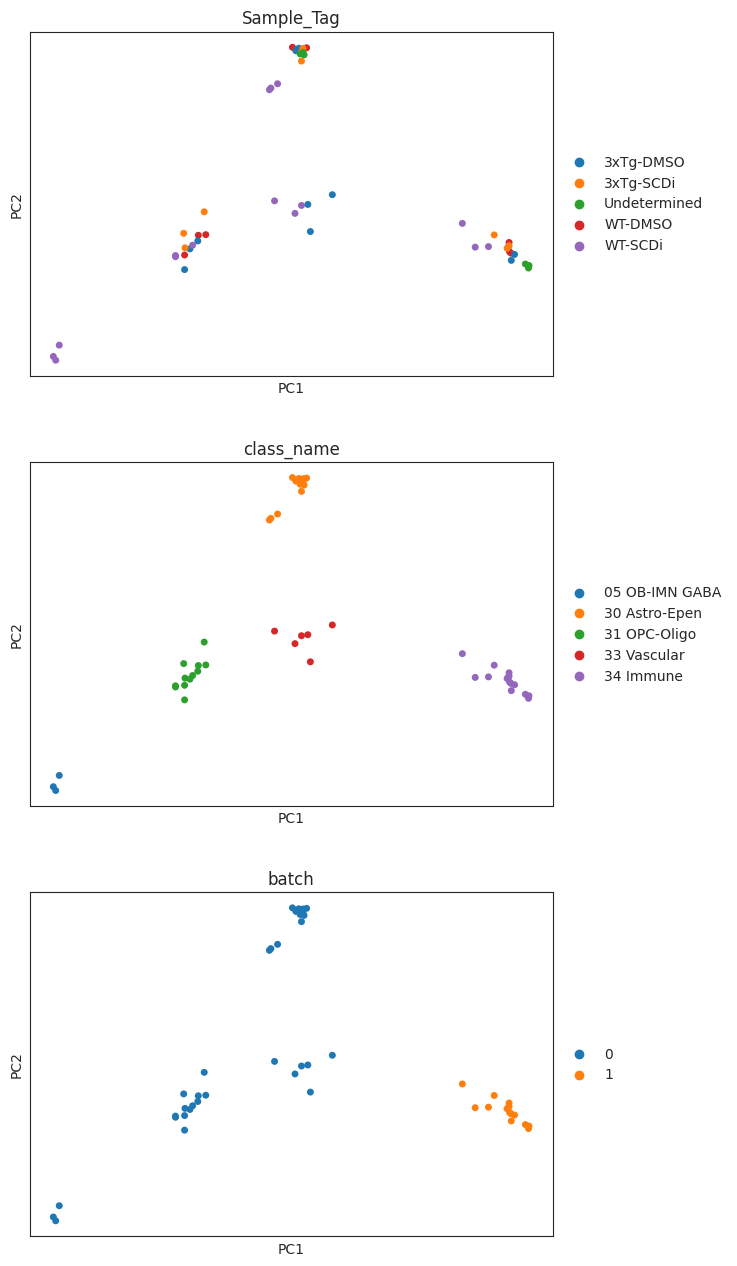

In [5]:
sc.pl.pca(adata_pb, color=adata_pb.obs, ncols=1, size=100)

### Create control and condition anndata objects

In [201]:
ctr_name = '_'
cnd_name = '_'

In [202]:
adata_pb.X = adata_pb.layers['counts'].copy()
adata_pb.X = adata_pb.X.astype(np.float32)

In [203]:
ctr_sample_tags = list(set(adata.obs['Sample_Tag'].values))
ctr_sample_tags = ['WT-DMSO']

cnd_sample_tags = list(set(adata.obs['Sample_Tag'].values))
cnd_sample_tags = ['WT-SCDi']

In [204]:
control_df = adata_pb[(adata_pb.obs['Sample_Tag'].isin(ctr_sample_tags)) & (adata_pb.obs['class_name'] == '30 Astro-Epen')].to_df()
condition_df = adata_pb[(adata_pb.obs['Sample_Tag'].isin(cnd_sample_tags)) & (adata_pb.obs['class_name'] == '30 Astro-Epen')].to_df()

In [205]:
results_df = deseq2_dea(control_df, condition_df, save_path=None)

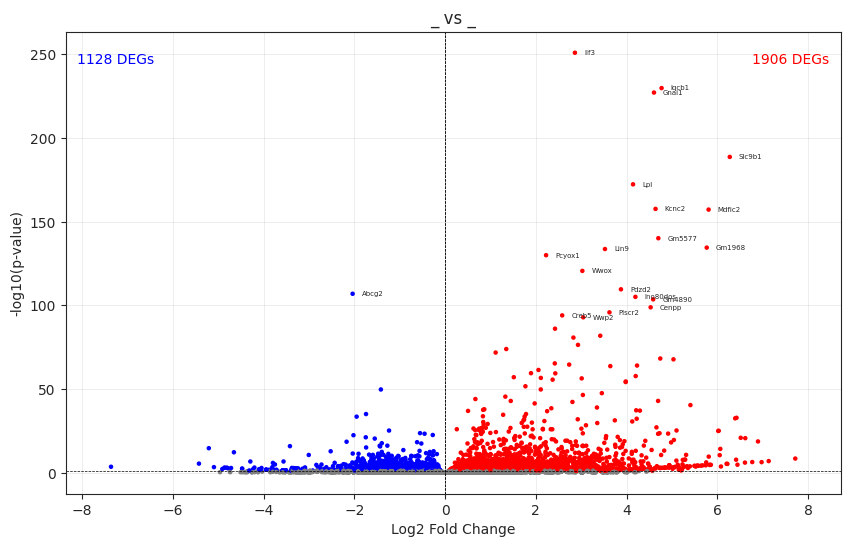

In [206]:
volcano_plot(results_df,
             min_fold_change=0,
             max_p_value=0.05,
             fig_title=f'{ctr_name} vs {cnd_name}',
             save_path=f'figures/{ctr_name}_{cnd_name}_volcano_plot.png')

# Differential gene expression analysis - Cell level

### Create control and condition anndata objects

In [159]:
ctr_name = '_'
cnd_name = '_'

In [160]:
adata.X = adata.layers['counts']
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

In [161]:
ctr_sample_tags = list(set(adata.obs['Sample_Tag'].values))
ctr_sample_tags = ['WT-DMSO']

cnd_sample_tags = list(set(adata.obs['Sample_Tag'].values))
cnd_sample_tags = ['3xTg-DMSO']

In [162]:
control_df = adata[(adata.obs['Sample_Tag'].isin(ctr_sample_tags)) & (adata.obs['class_name'] == '30 Astro-Epen')].to_df()
condition_df = adata[(adata.obs['Sample_Tag'].isin(cnd_sample_tags)) & (adata.obs['class_name'] == '30 Astro-Epen')].to_df()

In [163]:
results_df = mast_dea(adata, control_df, condition_df, save_path=None)

[1] "Shape of exprs_data: 25244 x 2944"
[1] "Shape of cdata: 2944 x 1"
[1] "Shape of fdata: 25244 x 1"


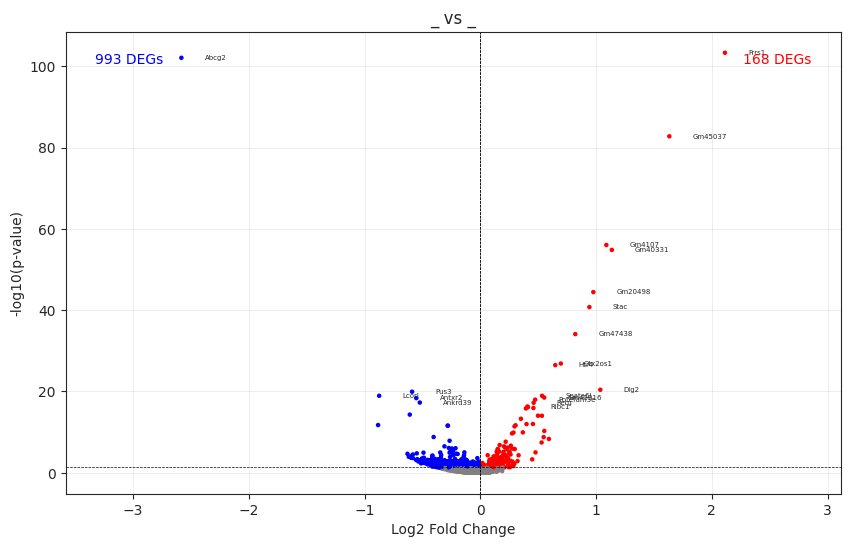

In [174]:
volcano_plot(results_df,
             min_fold_change=0,
             max_p_value=0.05,
             fig_title=f'{ctr_name} vs {cnd_name}',
             save_path=f'figures/{ctr_name}_{cnd_name}_volcano_plot.png')

# Gene set and pathway enrichment analysis

In [208]:
UP_genes_name, DOWN_genes_name = get_DEGs(results_df,
                                          max_pval=0.05,
                                          min_fold_change=0)

In [209]:
UP_GO = go_enrichment_analysis(UP_genes_name, save_path=None)
DOWN_GO = go_enrichment_analysis(DOWN_genes_name, save_path=None)

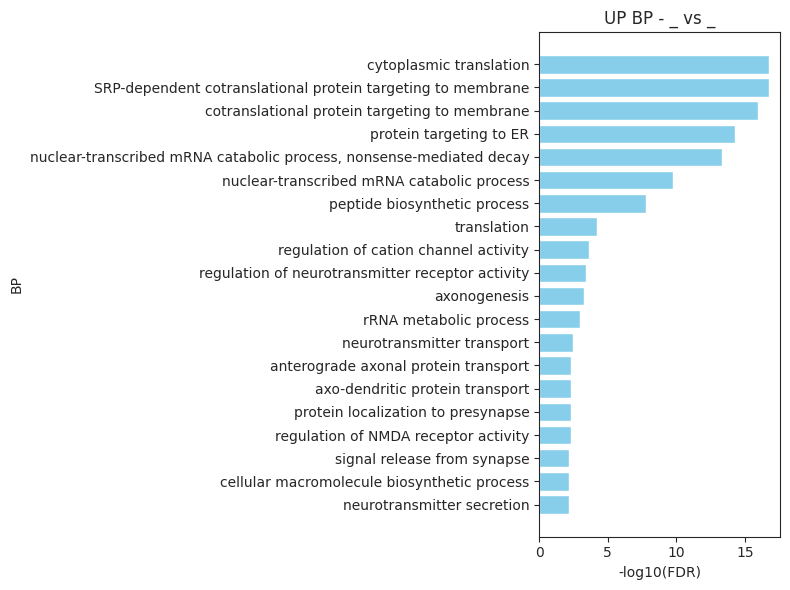

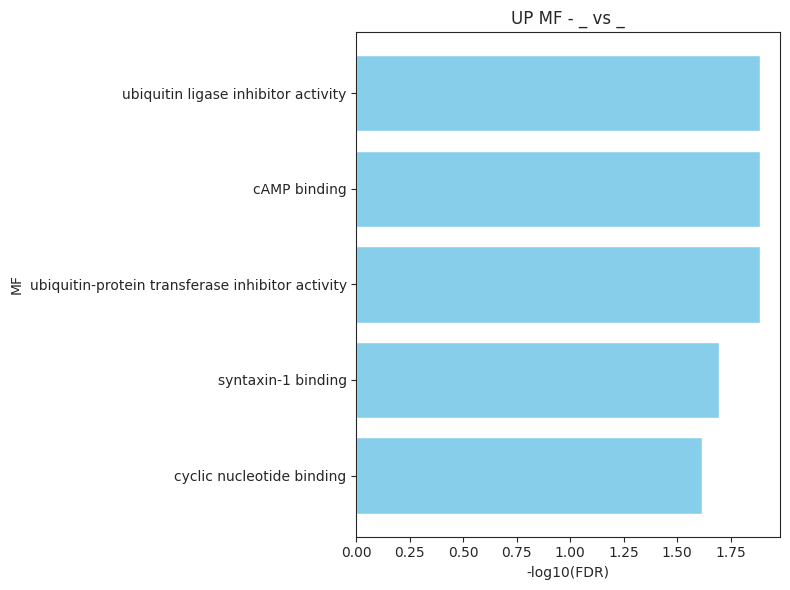

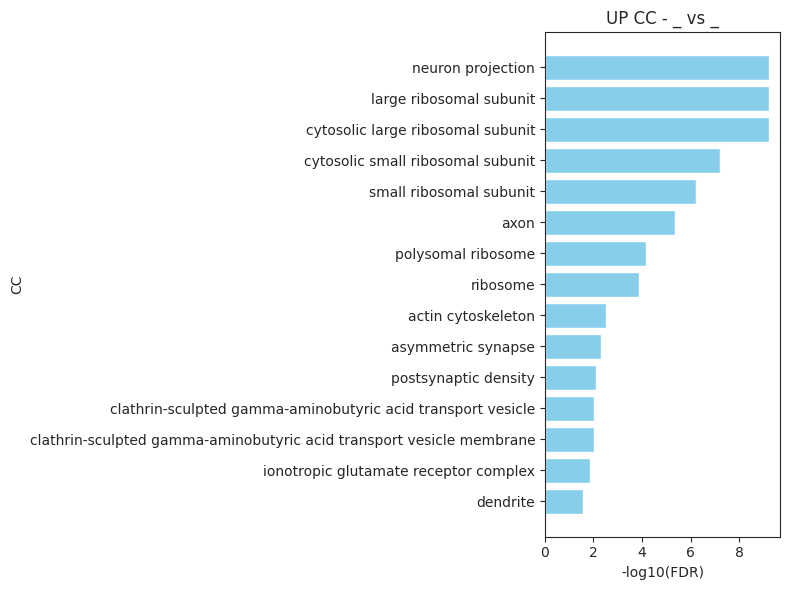

In [217]:
display_go_enrichment(UP_GO,
                      namespace='BP',
                      fig_title=f'UP BP - {ctr_name} vs {cnd_name}',
                      save_path=f'figures/{ctr_name}_{cnd_name}_display_GO_enrichment_UP_BP')

display_go_enrichment(UP_GO, 
                      namespace='MF',
                      fig_title=f'UP MF - {ctr_name} vs {cnd_name}',
                      save_path=f'figures/{ctr_name}_{cnd_name}_display_GO_enrichment_UP_MF')

display_go_enrichment(UP_GO, 
                      namespace='CC',
                      fig_title=f'UP CC - {ctr_name} vs {cnd_name}',
                      save_path=f'figures/{ctr_name}_{cnd_name}_display_GO_enrichment_UP_CC')

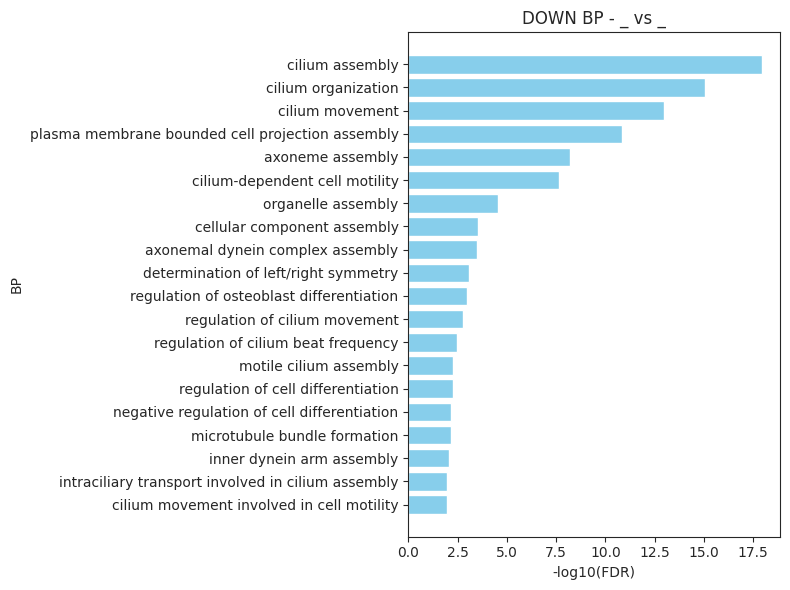

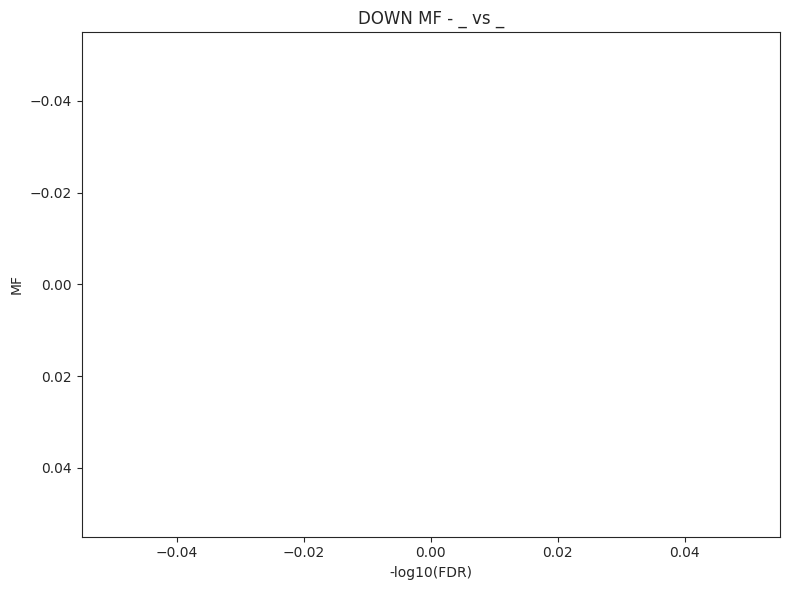

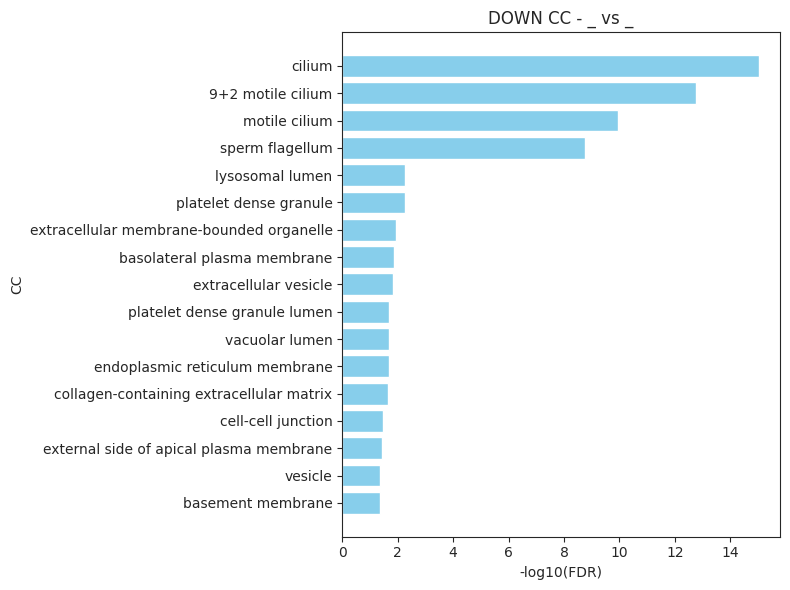

In [218]:
display_go_enrichment(DOWN_GO, 
                      namespace='BP',
                      fig_title=f'DOWN BP - {ctr_name} vs {cnd_name}',
                      save_path=f'figures/{ctr_name}_{cnd_name}_display_GO_enrichment_DOWN_BP')

display_go_enrichment(DOWN_GO, 
                      namespace='MF',
                      fig_title=f'DOWN MF - {ctr_name} vs {cnd_name}',
                      save_path=f'figures/{ctr_name}_{cnd_name}_display_GO_enrichment_DOWN_MF')

display_go_enrichment(DOWN_GO, 
                      namespace='CC',
                      fig_title=f'DOWN CC - {ctr_name} vs {cnd_name}',
                      save_path=f'figures/{ctr_name}_{cnd_name}_display_GO_enrichment_DOWN_CC')

In [212]:
UP_KEGG = kegg_enrichment_analysis(UP_genes_name, 
                                   save_path=None)

In [213]:
DOWN_KEGG = kegg_enrichment_analysis(DOWN_genes_name, 
                                     save_path=None)

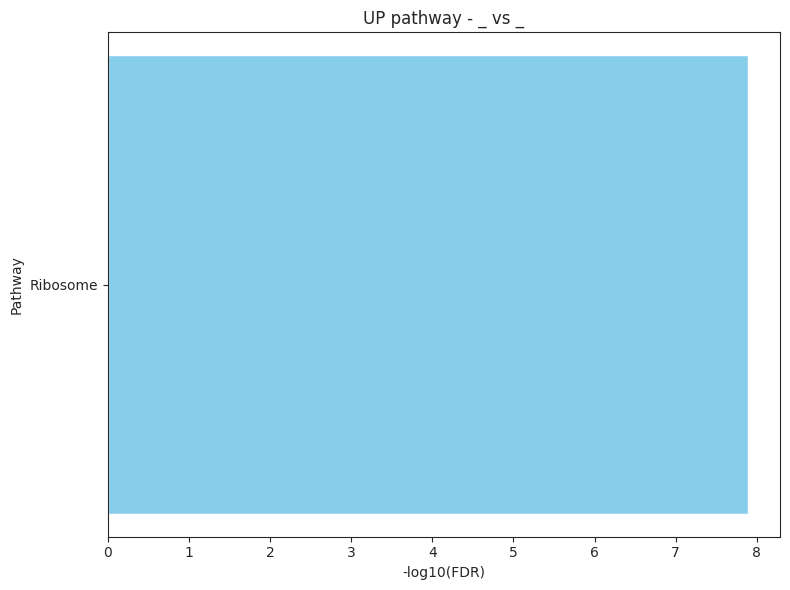

In [219]:
display_kegg_enrichment(UP_KEGG,
                        fig_title=f'UP pathway - {ctr_name} vs {cnd_name}',
                        save_path=f'figures/{ctr_name}_{cnd_name}_display_KEGG_enrichment_UP')

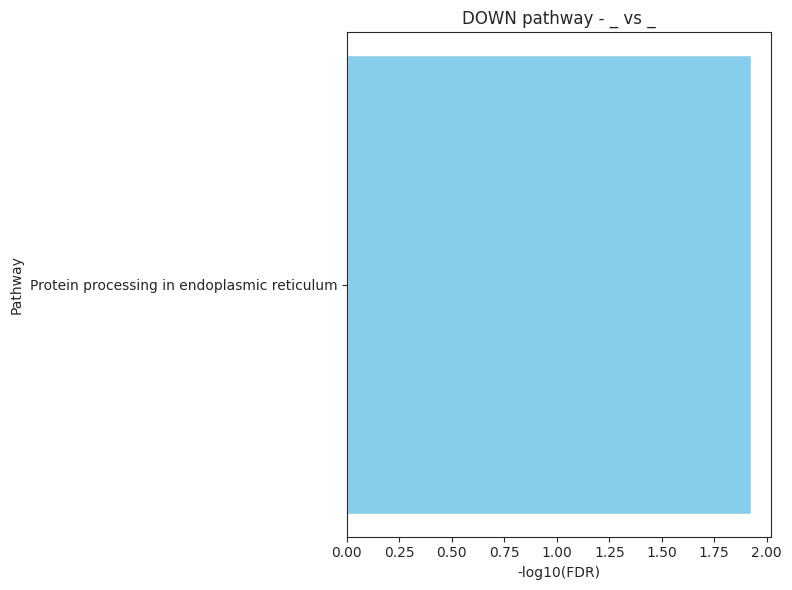

In [220]:
display_kegg_enrichment(DOWN_KEGG,
                        fig_title=f'DOWN pathway - {ctr_name} vs {cnd_name}',
                        save_path=f'figures/{ctr_name}_{cnd_name}_display_KEGG_enrichment_DOWN')